In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from matplotlib import rcParams
import pandas as pd
import os, requests
import sys

In [3]:
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 10
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
# Local
file_directory = '../data/'
sys.path.append(file_directory)

In [6]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [7]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

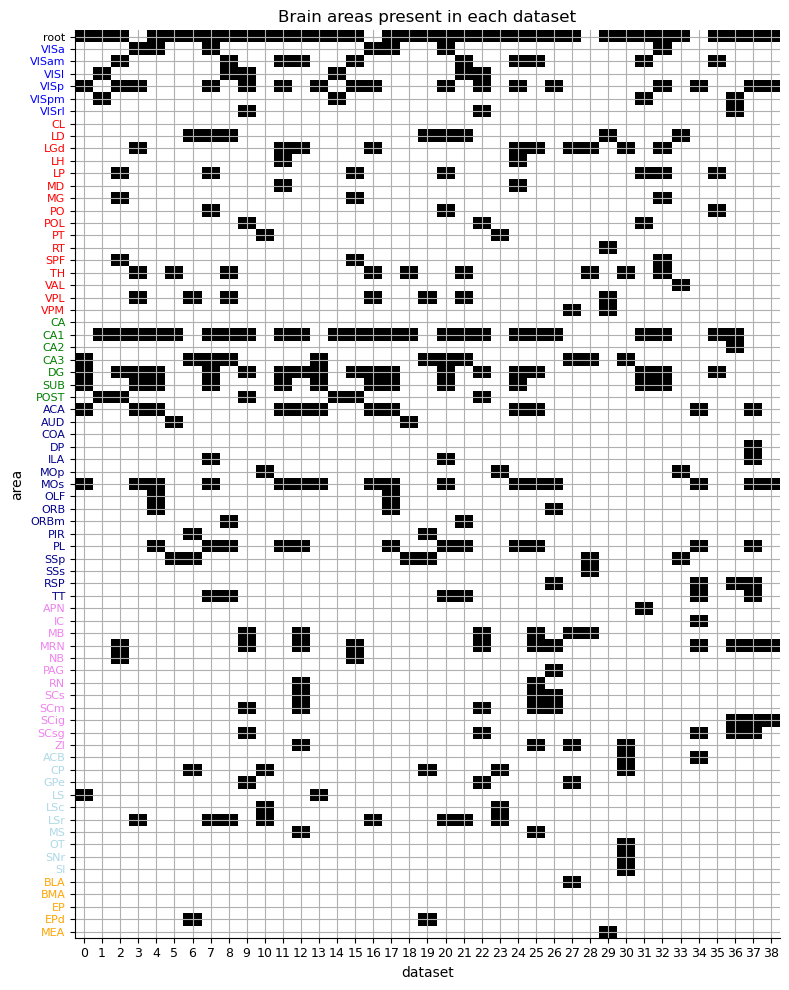

In [8]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()


# Analysis

### to-do's:
- fix that the data is not bool but int with the amount of spikes per bin.
- fix filtering by contrast and reward.

In [9]:
nsessions = alldat.shape[0]
nsessions

39

In [10]:
#@title Load from one session
session = 3 #@param {type:"integer"}
dat = alldat[session]
spikes = dat['spks']
dt = dat['bin_size']
n_neurons, n_trials, NT = spikes.shape

n_neurons, n_trials, NT # NT total time (bins)

(1769, 249, 250)

In [11]:
dat['response_time'].shape #response per trial

(249, 1)

In [12]:
#@title Identify neuron indices with activity in brain subgroup
subgroup = 0 #@param {type:"integer"}
dat['brain_area'].shape # brain area per neuron
neurons_indices = np.where( dat['brain_area']== brain_groups[0][subgroup])[0]
print(brain_groups[0][subgroup], neurons_indices.shape, neurons_indices)

VISa (81,) [568 571 582 583 593 611 612 614 616 617 630 637 638 644 655 664 671 673
 674 678 684 685 686 690 697 703 710 721 729 731 734 747 749 750 751 752
 754 757 758 761 762 765 768 772 776 778 790 791 795 804 805 807 808 809
 828 829 835 840 844 850 852 857 859 872 877 878 881 883 884 887 892 896
 901 905 906 910 924 926 931 933 934]


In [13]:
# i = 0

In [14]:
# for j in range(len(neurons_indices)):
#   neuron = neurons_indices[i]
# i=i+1
neuron = 582 #@param {type:"integer"}

# neuron = 568, 655

In [15]:
#@title Mask contrast-reward
left_contrast_reward = (dat['contrast_left']>dat['contrast_right']) & (dat['response']==1) & (dat['feedback_type']==1) #resp =1
left_contrast_reward_spikes = spikes[:][:,left_contrast_reward,:] #spikes[neurons_indices]

left_contrast_penalty = (dat['contrast_left']>dat['contrast_right']) & (dat['response']==1) & (dat['feedback_type']==-1) #Should be empty (response correct, but penalty) response =! 1
left_contrast_penalty_spikes = spikes[:][:,left_contrast_penalty,:]

right_contrast_reward = (dat['contrast_left']<dat['contrast_right']) & (dat['response']==-1) & (dat['feedback_type']==1) #resp = -1
right_contrast_reward_spikes = spikes[:][:,right_contrast_reward,:]

right_contrast_penalty = (dat['contrast_left']<dat['contrast_right']) & (dat['response']==-1) & (dat['feedback_type']==-1) #Should be empty (response correct, but penalty) response += -1
right_contrast_penalty_spikes = spikes[:][:,right_contrast_penalty,:]

print(right_contrast_reward.shape)
print(right_contrast_reward_spikes.shape)

(249,)
(1769, 55, 250)


In [16]:
time_ms = dt * np.arange(NT)*1000
time_ms

alignment = 'onset stimulus'
time_align = -500


In [17]:
left_contrast_reward_spikes[neuron].shape

(44, 250)

In [18]:
left_contrast_reward_spikes[neuron][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [19]:
def calculate_psth(contrast_reward_spikes, neuron):
  sum_spikes = np.sum(contrast_reward_spikes[neuron], axis=0)
  psth = sum_spikes/(0.01*contrast_reward_spikes[neuron].shape[0])
  return psth

In [20]:
def find_spike_timestamps(contrast_reward_spikes,  neuron=neuron,
                    time_align=-500, time_ms=time_ms):

  spike_timestamps = []
  for neuron_spikes in contrast_reward_spikes[neuron]:
    bool_arr = neuron_spikes.astype(bool)
    spike_times = time_ms[bool_arr]+time_align
    spike_timestamps.append(spike_times)
  return spike_timestamps

In [22]:
#Trials contrast difference

def contrast_diff(contrast_reward, contrast_side):
  if contrast_side == 'left':
    contrast_dif = dat['contrast_left'][contrast_reward]-dat['contrast_right'][contrast_reward]
  elif contrast_side == 'right':
    contrast_dif = dat['contrast_left'][left_contrast_reward]-dat['contrast_right'][left_contrast_reward]
  return contrast_dif


In [21]:
def plot_raster(spike_timestamps, alignment, session, neuron, contrast_reward,
                contrast_side, time_align=-500, tamano_y=1):

  region=dat['brain_area'][neuron]
  fig, ax = plt.subplots(4,1, figsize=(7, 7), sharex=True,
                        gridspec_kw={'height_ratios': [2,1,1,1]})

  delta_contrast = contrast_diff(contrast_reward, contrast_side)
  indices_contrast_order = np.argsort(delta_contrast)
  unique_contrasts = set()

  for y_order, trial_number in enumerate(indices_contrast_order):
    label = None
    if delta_contrast[trial_number] not in unique_contrasts:
        label = f'$\Delta$C= {delta_contrast[trial_number]}'
        unique_contrasts.add(delta_contrast[trial_number])

    ax[0].eventplot(spike_timestamps[trial_number], linelengths=1,
                      color='black', lineoffsets=y_order,
                    alpha=delta_contrast[trial_number])#, label=label)


    if delta_contrast[trial_number] != 1.0:
      ax[0].add_patch(plt.Rectangle((2050, y_order-0.5), 100, tamano_y,
                                    color=plt.cm.gray(1-float(delta_contrast[trial_number]))))
    elif delta_contrast[trial_number] == 1.0:
      ax[0].add_patch(plt.Rectangle((2050, y_order-0.5), 100, tamano_y,
                                    color=plt.cm.gray(1)))


  ax[0].axvline(x = 0, color='salmon', linestyle='--', label='Stim onset', lw=0.8)
  ax[0].set_ylabel("Trial")
  ax[0].set_title(f"""Raster plot aligned to {alignment} (session: {session}, neuron: {neuron}, region:{region}) """)
  ax[0].legend(loc='lower center')#, bbox_to_anchor=(1, 1))

  ax[1].plot(time_ms+time_align, psth)
  ax[1].set_ylabel('Firing rate (Hz)')

  eye_hor_pos = dat['pupil'][1, contrast_reward,: ]
  eye_hpos_mean = np.mean(eye_hor_pos, axis=0)
  eye_hpos_sd = np.std(eye_hor_pos, axis=0)

  sp_wheel = dat['wheel'][0, contrast_reward,: ]
  sp_wheel_mean = np.mean(sp_wheel, axis=0)
  sp_wheel_sd = np.std(sp_wheel, axis=0)

  ax[2].plot(time_ms+time_align, eye_hpos_mean)
  ax[2].fill_between(time_ms+time_align, eye_hpos_mean-eye_hpos_sd, eye_hpos_mean+eye_hpos_sd,
                     alpha=0.5)
  ax[2].set_ylabel(f'Pupil h-pos')

  ax[3].plot(time_ms+time_align, sp_wheel_mean)
  ax[3].fill_between(time_ms+time_align, sp_wheel_mean-sp_wheel_sd, sp_wheel_mean+sp_wheel_sd,
                     alpha=0.5)
  ax[3].set_ylabel(f'Wheel speed')
  ax[3].set_xlabel(f"Time from {alignment} (ms)")

  plt.tight_layout()
  plt.show()

In [23]:
contrast_dif = contrast_diff(left_contrast_reward, 'left')
contrast_dif

array([0.75, 0.5 , 0.5 , 1.  , 0.5 , 0.25, 0.75, 0.5 , 0.5 , 0.75, 0.75,
       0.25, 0.75, 0.25, 0.5 , 0.5 , 1.  , 0.25, 0.75, 0.5 , 0.25, 0.5 ,
       1.  , 0.25, 0.25, 0.5 , 0.5 , 0.25, 0.25, 0.5 , 0.5 , 0.5 , 1.  ,
       0.75, 0.75, 0.25, 0.5 , 0.75, 1.  , 0.25, 0.5 , 0.25, 0.5 , 0.75])

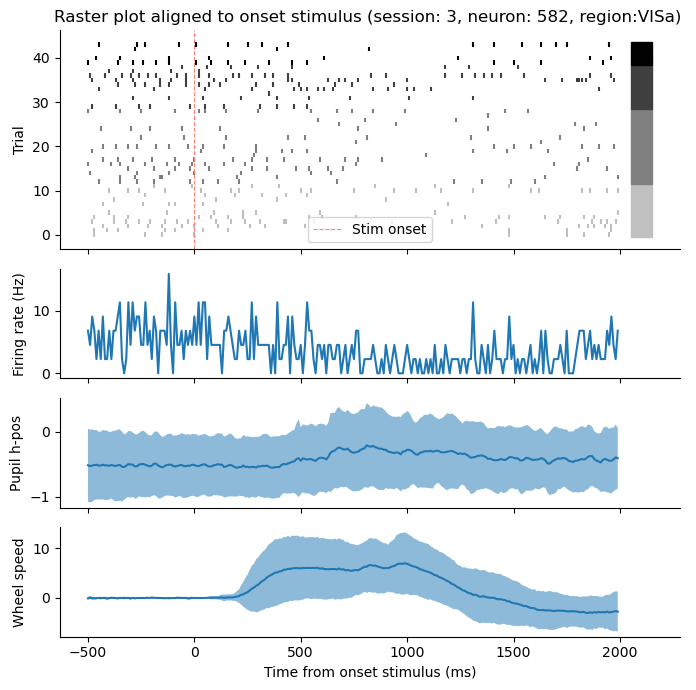

In [24]:
contrast_reward_spikes = left_contrast_reward_spikes
contrast_reward=left_contrast_reward
contrast_side='left'

psth = calculate_psth(contrast_reward_spikes = contrast_reward_spikes, neuron=neuron)
spike_timestamps = find_spike_timestamps(contrast_reward_spikes = contrast_reward_spikes)
plot_raster(spike_timestamps, alignment, session=session, neuron=neuron,
            contrast_reward=contrast_reward, contrast_side=contrast_side,
            tamano_y=1)

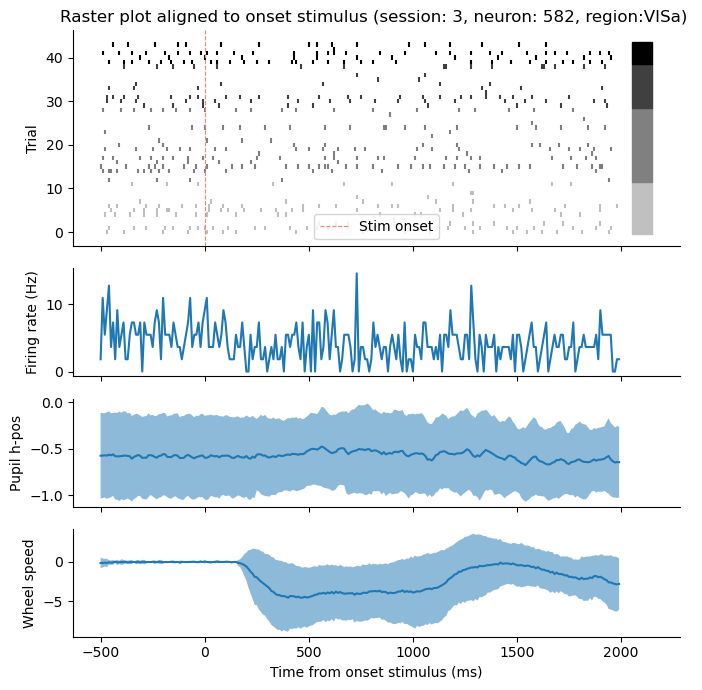

In [25]:
contrast_reward_spikes = right_contrast_reward_spikes
contrast_reward=right_contrast_reward
contrast_side="right"

psth = calculate_psth(contrast_reward_spikes = contrast_reward_spikes, neuron=neuron)
spike_timestamps = find_spike_timestamps(contrast_reward_spikes = contrast_reward_spikes)
plot_raster(spike_timestamps, alignment, session, neuron, contrast_reward=contrast_reward,
            contrast_side=contrast_side, tamano_y=1)


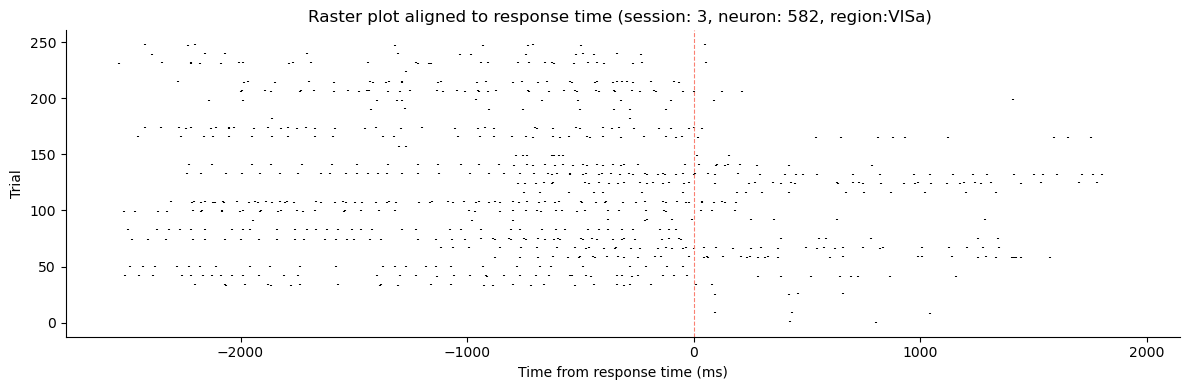

In [26]:
# Plot raster
alignment = 'response time'
plt.figure(figsize=(12, 4))

for trial in range(n_trials):
  time_align = -1000*dat['response_time'][trial][0]

  bool_arr = spikes[neuron][trial].astype(bool)
  spike_times = time_ms[bool_arr]
  plt.eventplot(spike_times + time_align, orientation='horizontal', linelengths=0.2,
                color='black', lineoffsets=trial)

  # plt.scatter(1000*dat['response_time'][trial][0]+time_align, trial, s=0.6,
  #             color='teal', alpha=0.5, label='Response time')

plt.axvline(x = 0, color='salmon', linestyle='--', label='Response time', lw=0.8)
plt.xlabel(f"Time from {alignment} (ms)")
plt.ylabel("Trial")
plt.title(f"Raster plot aligned to {alignment} (session: {session}, neuron: {neuron}, region:{dat['brain_area'][neuron]}) ")
plt.show()

In [27]:
# # # neuron = 307 #@param {type:"integer"}

# # Plot raster
# plt.figure(figsize=(10, 4))

# for trial in range(n_trials):
#   bool_arr = spikes[neuron][trial].astype(bool)
#   spike_times = time_ms[bool_arr]
#   plt.eventplot(spike_times + time_align, orientation='horizontal', linelengths=0.2,
#                 color='black', lineoffsets=trial)

#   # plt.scatter(1000*dat['response_time'][trial][0]+time_align, trial, s=0.6,
#   #             color='teal', alpha=0.5, label='Response time')

#   # plt.scatter(1000*dat['feedback_time'][trial]+time_align, trial, s=0.6,
#   #             color='orange', alpha=0.5, label='Feedback time')

# plt.axvline(x = 0, color='salmon', linestyle='--', label='Stimulus onset', lw=0.8)
# plt.xlabel(f"Time from {alignment} (ms)")
# plt.ylabel("Trial")
# plt.title(f"""Raster plot aligned to {alignment} (session: {session}, neuron: {neuron}, region:{dat['brain_area'][neuron]}) """)
# plt.show()

In [28]:
# #cada elemento es un trial
# contrast1=np.array([2,3,6,8])
# contrast2=np.array([4,4,9,11])

# delta_contrast = contrast2-contrast1
# print('delta contrast:', delta_contrast)

# indices_contrast_order = np.argsort(delta_contrast)
# print('indices_contrast_order:', indices_contrast_order)

# #cada lista es un trial, todos son la misma neurona
# spikes_neu_eg = [[2,7,1,8],[5,7,6,1],[6,2,8],[3,1,10,6,8]]



# fig, ax = plt.subplots(figsize=(5, 3))

# unique_contrasts = set()

# for i, trial_n in enumerate(indices_contrast_order):
#     label = None
#     if delta_contrast[trial_n] not in unique_contrasts:
#         label = f'delta Contrast = {delta_contrast[trial_n]}'
#         unique_contrasts.add(delta_contrast[trial_n])

#     ax.eventplot(spikes_neu_eg[trial_n], linelengths=0.5,
#                  color='black', lineoffsets=i, alpha=delta_contrast[trial_n]/max(delta_contrast),
#                  label=label)

# for i, intensity in enumerate(delta_contrast):
#   if intensity/max(delta_contrast) != 1.0:
#     ax.add_patch(plt.Rectangle((12, i - 0.5), 1, 1, color=plt.cm.gray((intensity/max(delta_contrast)))))
#   elif intensity/max(delta_contrast) == 1.0:
#     ax.add_patch(plt.Rectangle((12, i - 0.5), 1, 1, color=plt.cm.gray(1)))
# plt.legend()
# plt.show()